<a href="https://colab.research.google.com/github/HalcyonForest/Time-Series-Forecasting/blob/main/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow
import random
import xgboost as xgb
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras import optimizers
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 276kB 3.9MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.20-cp37-cp37m-linux_x86_64.whl size=1436218 sha256=3f9a31a3629d08bc94d6b61ac2575e77edd90f0e0ec573e0e8d2aed96b24b71a
  Stored in directory: /root/.cache/pip/wheels/d9/2f/34/7636a227222011ad010012e6bdf3a2abfaf1da255d9bdd532b
Successfully built ta-lib


# Functions_1

In [4]:
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
  # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
    if out_end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

def tickSlicing(data, tickRate, windowSize, predictSize, label):
  data = data[::tickRate]

  X = np.reshape(np.array(data[label]), (len(data[label]),-1))
  Y = np.reshape(np.array(data[label]), (len(data[label]), -1))

  data = []
  data = np.hstack((X, Y))
  # Переделать под слайсинг двух параметров - Close + vol upd:DONE
  X, y = split_sequences(data, windowSize, predictSize)
  # посплитили, добавляем фичи
  return X, y

def y_to_plot(y, y_step):
  y = np.reshape(y[::y_step], (-1))
  return y

def window_predict_in_seconds(tickrate, window, horizon):
  print("Смотрим каждый ", tickrate, "-ый тик, за последние ",tickrate * window ,"минут")
  print("предсказываем на ",tickrate * horizon ," минут вперед")

def plot_history(history_arr):
  for history in history_arr:
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'validation'])
    plt.title('Loss')
    plt.show()

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100


def metrics(y_test, y_pred):
  print("MSE: ", mean_squared_error(y_test, y_pred) )
  print("MAE: ", mean_absolute_error(y_test, y_pred))
  print("MAPE", mean_absolute_percentage_error(y_test, y_pred))


# Load and prepare data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Binance_BTCUSDT_minute.csv')
#df = pd.read_csv('/content/drive/MyDrive/Binance_ETHUSDT_minute.csv')
windowSize = 10
n_steps_out = 1
df.index = df['date']

df = df.rename(columns={'Volume USDT':'volume'})
# df = df.rename(columns={'Volume USDT':'volume'})
df = df.sort_index(ascending=True)
#print(df.head())
df = df.iloc[-200000:]
df = df.drop(columns=['unix', 'symbol', 'date'])
#df=df.drop(columns=[])
#print(df.head())
CLOSE = df['close']

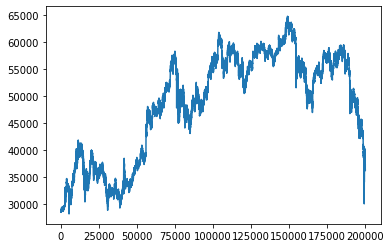

In [4]:
plt.plot(range(len(df['close'])) , df['close'].values) # Non stationary time series

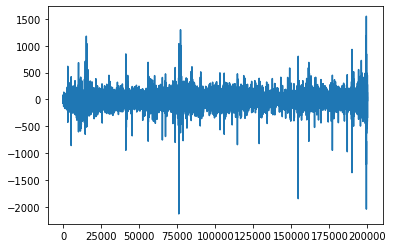

In [5]:
plt.plot(range(len(df['close'])) , df['close'].diff().values) # Stationary time series

In [6]:
tech_features = pd.DataFrame()

tech_features['MA'] = talib.MA(df['close'], matype=2)
tech_features['EMA'] = talib.EMA(df['close'])

tech_features['MIDPOINT'] = talib.MIDPOINT(df['close'],timeperiod=windowSize)
tech_features['UPPERBAND'], tech_features['MIDDLEBAND'], tech_features['LOWERBAND'] = talib.BBANDS(df['close'],timeperiod=windowSize)
tech_features['KAMA'] = talib.KAMA(df['close'], timeperiod=199)

# PPO                  Percentage Price Oscillator
# ROC                  Rate of change : ((price/prevPrice)-1)*100
# ROCP                 Rate of change Percentage: (price-prevPrice)/prevPrice
# RSI                  Relative Strength Index
# TRIX                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA

tech_features['TRIX'] = talib.TRIX(df['close'])
tech_features['RSI'] = talib.RSI(df['close'])
tech_features['ROC'] = talib.ROC(df['close'])
tech_features['ROCP'] = talib.ROCP(df['close'])
tech_features['PPO'] = talib.PPO(df['close'])

tech_features['TRIMA'] = talib.TRIMA(df['close'])
tech_features['SAR'] = talib.SAR(df['high'], df['low'])
tech_features['ADX'] = talib.ADX(df['high'], df['low'], df['close'])
tech_features['APO'] = talib.APO(df['close'])
tech_features['CMO'] = talib.CMO(df['close'])
tech_features['DX'] = talib.DX(df['high'], df['low'], df['close'])
tech_features['MFI'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
tech_features['MOM'] = talib.MOM(df['close'])

tech_features['ULTOSC'] = talib.ULTOSC(df['high'], df['low'], df['close'])

tech_features['AD'] = talib.AD(df['high'], df['low'], df['close'], df['volume'])
tech_features['ADOSC'] = talib.ADOSC(df['high'], df['low'], df['close'], df['volume'])
tech_features['OBV'] = talib.OBV(df['close'], df['volume'])

tech_features['NATR'] = talib.NATR(df['high'], df['low'], df['close'])

tech_features['AVGPRICE'] = talib.AVGPRICE(df['open'], df['high'], df['low'], df['close'])
tech_features['MEDPRICE'] = talib.MEDPRICE(df['high'], df['low'])
tech_features['TYPRICE'] = talib.TYPPRICE(df['high'], df['low'], df['close'])

tech_features['WCLPRICE'] = talib.WCLPRICE(df['high'], df['low'], df['close'])
tech_features['HT_PHASOR'] = talib.HT_DCPERIOD(df['close'])
tech_features['HT_TRENDLINE'] = talib.HT_TRENDLINE(df['close'])

tech_features['CDL2CROWS'] = talib.CDL2CROWS(df['open'], df['high'], df['low'], df['close'])
tech_features['CDL3LINESTRIKE'] = talib.CDL3LINESTRIKE(df['open'], df['high'], df['low'], df['close'])
tech_features['CDLBREAKAWAY'] = talib.CDLBREAKAWAY(df['open'], df['high'], df['low'], df['close'])
tech_features['CDLEVENINGDOJISTAR'] = talib.CDLEVENINGDOJISTAR(df['open'], df['high'], df['low'], df['close'])

tech_features['AROONOSC'] = talib.AROONOSC(df['high'], df['low'])
tech_features['BOP'] = talib.BOP(df['open'], df['high'], df['low'], df['close'])

tech_features['MA10'] = talib.MA(df['close'], timeperiod=10)
tech_features['MA50'] = talib.MA(df['close'], timeperiod=50)
tech_features['MA200'] = talib.MA(df['close'], timeperiod=200)
tech_features['MINUS_DI'] = talib.MINUS_DI(df['high'], df['low'], df['close'])
tech_features['MINUS_DM'] = talib.MINUS_DM(df['high'], df['low'])
tech_features['PLUS_DI'] = talib.PLUS_DI(df['high'], df['low'], df['close'])
tech_features['PLUS_DM'] = talib.PLUS_DM(df['high'], df['low'])

tech_features['HT_DCPERIOD'] = talib.HT_DCPERIOD(df['close'])
tech_features['HT_DCPHASE'] = talib.HT_DCPHASE(df['close'])
tech_features['ATR'] = talib.ATR(df['high'], df['low'], df['close'])


tech_features['BETA'] = talib.BETA(df['high'], df['low'])
tech_features['CORREL'] = talib.CORREL(df['high'], df['low'])
tech_features['STDDEV'] = talib.STDDEV(df['close'])
tech_features['VAR'] = talib.VAR(df['close'])

In [7]:
D = df.copy()
D = D.diff()
D = D.dropna()
tech_features = tech_features.dropna()
ndl = D.shape[0] - tech_features.shape[0] 
D = D.iloc[ndl:]
D = D.dropna()
n_steps_in = windowSize
tickrate = 1
window_predict_in_seconds(tickrate, windowSize, n_steps_out)

X_close, y_close = tickSlicing(D, tickrate, n_steps_in, n_steps_out, 'close')
tech_features = tech_features.iloc[tech_features.shape[0]-X_close.shape[0]:]

X_close = np.reshape(X_close, (X_close.shape[0], -1))

print(tech_features.shape, X_close.shape)

X_close = pd.DataFrame(X_close, index=tech_features.index)

X = pd.concat([X_close, tech_features], axis=1)
vol_dict = {i: 'VOL'+str(i) for i in range(windowSize,windowSize * 2)}
price_dict = {i: 'PRICE'+str(i) for i in range(windowSize)}
X = X.rename(columns=price_dict)
X = X.rename(columns=vol_dict)

print(X.shape, CLOSE.shape)

CLOSE_normal = CLOSE.iloc[CLOSE.shape[0] - X.shape[0]:]
print(CLOSE_normal.shape)

y = y_close
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
CLOSE_train, CLOSE_test = train_test_split(CLOSE_normal, train_size=0.8, shuffle=False)
train_scaler = StandardScaler()
test_scaler = StandardScaler()

X_train = train_scaler.fit_transform(X_train)
X_test = test_scaler.fit_transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, shuffle=False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_scaler = StandardScaler()
y_scaler.fit(y_test)

y_test_plot =  y_to_plot(y_test, n_steps_out)

first_test_price = CLOSE[y_train.shape[0]]

Смотрим каждый  1 -ый тик, за последние  20 минут
предсказываем на  1  минут вперед
(199782, 51) (199782, 20)
(199782, 71) (200000,)
(199782,)
(199782, 71) (199782, 1)
(143842, 71) (39957, 71) (143842, 1) (39957, 1)


# Normal things

In [10]:
epochs = 10
batch = 128
lr = 0.0003
adam = optimizers.Adam(lr)

model_mlp = Sequential()
model_mlp.add(Dense(512, activation='relu', input_dim=(X_train.shape[1])))
model_mlp.add(Dropout(0.5))
# model_mlp.add(Dense(64, activation='relu'))
# model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mae', optimizer=adam)
model_mlp.summary()

mlp_history = model_mlp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=1)
y_mlp = model_mlp.predict(X_test)
metrics(y_test, y_mlp)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               36864     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 37,377
Trainable params: 37,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4496/4496 [==============================] - 10s 2ms/step - loss: 11.1242 - val_loss: 2.8049
Epoch 2/10
4496/4496 [==============================] - 9s 2ms/step - loss: 3.7612 - val_loss: 1.5270
Epoch 3/10
4496/4496 [==============================] - 9s 2ms/step - loss: 2.9582 - val_loss: 0.9493
Epoch 4/10
4496/4496 [==============================] - 9s 2ms/step - lo

In [9]:
X_train_lstm = X_train.reshape((X_train.shape[0],1,-1))
X_test_lstm = X_test.reshape((X_test.shape[0],1, -1))
X_val_lstm = X_val.reshape((X_val.shape[0],1,-1))

In [74]:
epochs = 10
batch = 256
lr = 0.001
adam = optimizers.Adam(lr)

model_lstm = Sequential()
model_lstm.add(LSTM(128, activation='relu', input_dim=(X_train.shape[1]), return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mse', optimizer=adam)
#model_lstm.summary()
lstm_history=model_lstm.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs=epochs, verbose=1)
y_lstm = model_lstm.predict(X_test_lstm)
metrics(y_test, y_lstm)

Epoch 1/10
4496/4496 [==============================] - 21s 4ms/step - loss: 476.4117 - val_loss: 56.6671
Epoch 2/10
4496/4496 [==============================] - 18s 4ms/step - loss: 149.4517 - val_loss: 61.9034
Epoch 3/10
4496/4496 [==============================] - 18s 4ms/step - loss: 131.2635 - val_loss: 26.0441
Epoch 4/10
4496/4496 [==============================] - 19s 4ms/step - loss: 123.2026 - val_loss: 22.9125
Epoch 5/10
4496/4496 [==============================] - 18s 4ms/step - loss: 114.6635 - val_loss: 17.0183
Epoch 6/10
4496/4496 [==============================] - 18s 4ms/step - loss: 107.8410 - val_loss: 11.8651
Epoch 7/10
4496/4496 [==============================] - 19s 4ms/step - loss: 105.1281 - val_loss: 14.7509
Epoch 8/10
4496/4496 [==============================] - 19s 4ms/step - loss: 103.4301 - val_loss: 10.5854
Epoch 9/10
4496/4496 [==============================] - 18s 4ms/step - loss: 100.5849 - val_loss: 26.3302
Epoch 10/10
4496/4496 [=======================

In [11]:
import lightgbm as lgb
y_train_r = np.reshape(y_train, (-1,))
c_lgbData = lgb.Dataset(X_train, label=y_train_r)
params = {}
params['learning_rate'] = 0.11
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 1
params['num_leaves'] = 31
params['min_data'] = 5
params['max_depth'] = 6
c_lgb = lgb.train(params, c_lgbData, 100)
c_pred = c_lgb.predict(X_test)
dt = len(y_test) // 3
metrics(y_test, c_pred)

MSE:  388.5896557218009
MAE:  8.117026524814241
MAPE 17.971362430748062


In [12]:
c_linreg = LinearRegression(n_jobs=-1)
c_linreg.fit(X_train, y_train)
y_linreg = c_linreg.predict(X_test)
metrics(y_test, y_linreg)

MSE:  135.3594784476686
MAE:  7.669869195942817
MAPE 26.44929260628307


In [13]:
from xgboost import XGBRegressor
xgbr = XGBRegressor(max_depth=6, learning_rate=0.25, n_estimators=100,n_jobs=-1)
xgbr.fit(X_train, y_train)
y_xgb = xgbr.predict(X_test)
metrics(y_test, y_xgb)

[08:15:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE:  135.78584942263842
MAE:  7.640552572149823
MAPE 25.90701369563451


In [ ]:
# 3 xgb experiment

from xgboost import XGBRegressor
xgbr1 = XGBRegressor(max_depth=4, learning_rate=0.25, n_estimators=200,n_jobs=-1)
xgbr2 = XGBRegressor(max_depth=4, learning_rate=0.25, n_estimators=200,n_jobs=-1)
xgbr3 = XGBRegressor(max_depth=4, learning_rate=0.25, n_estimators=200,n_jobs=-1)
dt = len(X_train) // 3
xgbr1.fit(X_train[:dt], y_train[:dt])
xgbr2.fit(X_train[dt:2*dt], y_train[dt: 2*dt])
xgbr3.fit(X_train[-dt:], y_train[-dt:])
y_xgb1 = xgbr1.predict(X_test)
y_xgb2 = xgbr2.predict(X_test)
y_xgb3 = xgbr3.predict(X_test)
print(y_xgb1.shape)
y_final = (y_xgb1 + y_xgb2 + y_xgb3) / 3
print(y_final.shape)
metrics(y_test, y_final)

[09:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:18:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:19:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
(39955,)
(39955,)
MSE:  188.37399488053023
MAE:  7.614965754633631
MAPE 21.128398723077442


In [26]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=0, max_depth=6)
rfr.fit(X_train, np.reshape(y_train, (-1,)))
y_rfr = rfr.predict(X_test)
metrics(y_test, y_rfr)

MSE:  177.86203533177357
MAE:  7.712413171499301
MAPE 17.47036631629971


In [ ]:
print(y_lgb_test.shape , y_linreg_test.shape , y_xgb_test.shape , y_rfr_test.shape, y_mlp_test.shape, y_lstm_test.shape)

(39959, 1) (39959, 1) (39959, 1) (39959, 1) (143849, 1) (143849, 1)


In [15]:
y_lgb = c_lgb.predict(X_train).reshape((-1,1))
y_linreg = c_linreg.predict(X_train).reshape((-1,1))
y_xgb = xgbr.predict(X_train).reshape((-1,1))
y_rfr = rfr.predict(X_train).reshape((-1,1))
y_mlp = model_mlp.predict(X_train).reshape((-1,1))
y_lstm = model_lstm.predict(X_train_lstm).reshape((-1,1))

y_lgb_test = c_lgb.predict(X_test).reshape((-1,1))
y_linreg_test = c_linreg.predict(X_test).reshape((-1,1))
y_xgb_test = xgbr.predict(X_test).reshape((-1,1))
y_rfr_test = rfr.predict(X_test).reshape((-1,1))
y_mlp_test = model_mlp.predict(X_test).reshape((-1,1))
y_lstm_test = model_lstm.predict(X_test_lstm).reshape((-1,1))


ensemble_train = np.hstack([y_lgb, y_linreg, y_xgb, y_rfr, y_mlp, y_lstm])
ensemble_test = np.hstack([y_lgb_test , y_linreg_test , y_xgb_test , y_rfr_test, y_mlp_test, y_lstm_test])
print(ensemble_train.shape, ensemble_test.shape)

#ensemble_model = XGBRegressor(n_jobs=-1, max_depth=2, n_estimators=100, learning_rate=0.001)
ensemble_model = LinearRegression()
ensemble_model.fit(ensemble_train, y_train)
y_ensemble = ensemble_model.predict(ensemble_test)
metrics(y_test, y_ensemble)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


(143849, 6) (39959, 6)
MSE:  135.35947844767034
MAE:  7.669869195942872
MAPE 26.44929260628311


In [16]:
print("~~~MLP~~~")
metrics(y_test, y_mlp_test)
print("______________________")
print("~~~LSTM~~~")
metrics(y_test, y_lstm_test)
print("______________________")
print("~~~Linreg~~~")
metrics(y_test, y_linreg_test)
print("______________________")
print("~~~LGBM~~~")
metrics(y_test, y_lgb_test)
print("______________________")
print("~~~XGBoost~~~")
metrics(y_test, y_xgb_test)
print("______________________")
print("~~~Random Forest~~~")
metrics(y_test, y_rfr_test)
print("______________________")
print("~~~Ensemble~~~")
metrics(y_test, y_ensemble)


~~~MLP~~~
MSE:  139.56321610148117
MAE:  7.72421800171441
MAPE 24.368170985841918
______________________
~~~LSTM~~~
MSE:  150.7764946776947
MAE:  8.17051599827634
MAPE 28.569927276490475
______________________
~~~Linreg~~~
MSE:  135.3594784476686
MAE:  7.669869195942817
MAPE 26.44929260628307
______________________
~~~LGBM~~~
MSE:  388.5896557218009
MAE:  8.117026524814241
MAPE 17.971362430748062
______________________
~~~XGBoost~~~
MSE:  135.78584942263842
MAE:  7.640552572149823
MAPE 25.907013690588865
______________________
~~~Random Forest~~~
MSE:  173.35194028311386
MAE:  7.710071771043495
MAPE 18.153637320378312
______________________
~~~Ensemble~~~
MSE:  135.35947844767034
MAE:  7.669869195942872
MAPE 26.44929260628311


In [17]:
def toPrice(price, deltas):
  deltas = np.array(deltas)
  return price + np.cumsum(deltas)


def plot_forecast(X_test, i, prices, x_scaler, model_c, model_v):
  y_multistep = one_to_multi(i, 5, model_c, model_v)
  y_multistep = np.reshape(y_multistep, (-1,))

  lastprice = prices[i]
  print(y_multistep)
  y_multistep = toPrice(lastprice, y_multistep)
  print(y_multistep)

  X_unscaled = x_scaler.inverse_transform(X_test[i])[:15]
  X_usc2 = x_scaler.inverse_transform(X_test[i+5])[:15]

  X_prices = toPrice(lastprice, X_unscaled)
  X_addit = toPrice(prices[i+5], X_usc2)[10:15]
  lenX = len(X_prices) + len(X_addit)

  X_to_plot = pd.DataFrame(np.hstack([X_prices, X_addit]), index=range(lenX))
  y_multistep = pd.DataFrame(y_multistep, index=range(lenX - 5 - 1 , lenX + len(y_multistep) - 5 - 1)) 

  plt.figure(figsize=(15,6))
  plt.plot(X_to_plot)
  plt.plot(y_multistep)
  plt.legend(['test', 'predict'])
  plt.title('BTC price')
  plt.show()

def total_2(model, X_test, y_test):
  y_pred = model.predict(X_test)
  print(y_pred)
  y_1 = np.reshape(y_test, (-1,))
  y_2 = np.reshape(y_pred, (-1,))
  print("MAE: ", mean_absolute_error(y_test, y_pred))
  print("MAPE: ",mean_absolute_percentage_error(y_1, y_2))

  print("Пример предсказания")
  i = random.randint(0, X_test.shape[0])

  print(y_pred[i])
  print(y_test[i])

  X_i_prices = toPrice(CLOSE_test[i],X_test[i])
  y_pred_prices = toPrice(CLOSE_test[i+15], y_pred[i])
  y_test_prices = toPrice(CLOSE_test[i+15], y_test[i])

  plt.figure(figsize=(15,6))
  plot_1 = np.hstack([X_i_prices, y_pred_prices]) 
  plot_2 = np.hstack([X_i_prices, y_test_prices])
  plt.plot(plot_1)
  plt.plot(plot_2)
  plt.legend(['test', 'predict'])
  plt.title('BTC price')
  plt.show()


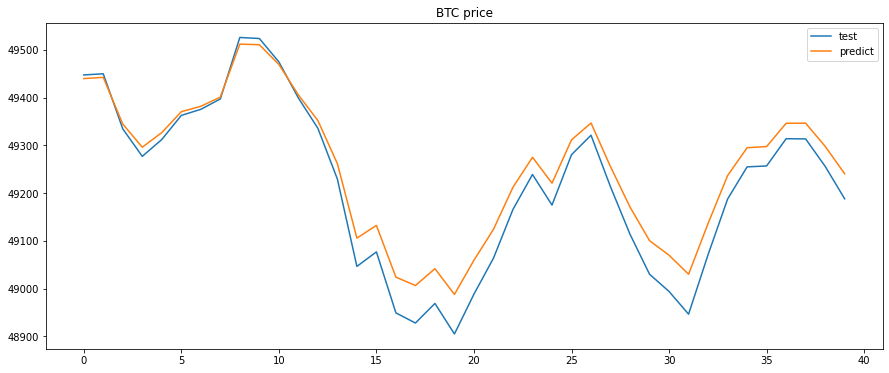

In [18]:
from random import randint
def plotForecast(model, X_test, y_test, prices, steps, i=10):
  i = randint(1, len(y_test))

  y_preds = []
  for j in range(steps):
    #print(X_test[i + j].shape)
    predict = model.predict([X_test[i + j]])[0]
    #predict += prices[i + j]
    y_preds.append(predict)

  y_preds_price = toPrice(CLOSE_test[i], y_preds)
  y_test_price = toPrice(CLOSE_test[i], y_test[i:i+steps])

  plt.figure(figsize=(15,6))
  plt.plot(y_test_price)
  plt.plot(y_preds_price)
  plt.legend(['test', 'predict'])
  plt.title('BTC price')
  plt.show()

plotForecast(xgbr, X_test, y_test, CLOSE_test, 40)

In [66]:
def trade(model, money, X_test, y_test, prices, steps=len(X_test), threshold=0.001, stoploss=0.08): 
  fee = 0.01 / 100
  buylast = False
  soldlast = False
  X_test = X_test[-steps:]
  y_test = y_test[-steps:]
  prices = prices[-steps:]
  coins = 0.5 * money / prices[0]
  cash = money * 0.5
  buyprice = prices[0]
  sellprice = prices[0]
  history = [money]
  for i in range(steps):
    current = prices[i]
    if (i == steps-1): 
      print("Current price: ", current, "coins: ", round(coins, 4), "cash: ", cash, "total: ", round(cash + coins * current * (1 - fee), 2))
    
    d = model.predict(np.array([X_test[i]]))
    if (not buylast and not soldlast) and abs(d) > current * threshold:
      if d > 0: 
        # Пойдет вверх => покупаем
        if (cash != 0):
          coins += (0.5*cash * (1 - fee)) / current
          buyprice=current
          buylast = True
          cash = 0.5*cash

      elif d < 0:
        # Пойде вниз => продаем , купим в след шаге(??)
        if (coins != 0):
          cash += (0.5 * coins  * (1 - fee)) * current
          sellprice = current
          soldlast = True
          coins = 0.5 * coins
    elif buylast:
      buylast = False
      cash += (0.5*coins * (1 - fee)) * current
      coins = 0.5 * coins
    elif soldlast:
      soldlast = False
      coins += (0.5*cash * (1 - fee)) / current
      cash = 0.5 * cash

    history.append(cash + coins * current)
  print("Start price: ", prices[0], "Close price: ", prices[-1])
  print("Passive profit: ", prices[-1] / prices[0] * money * (1 - fee))
  #plt.plot(range(len(history)), history)

Current price:  36343.0 coins:  0.008 cash:  582.7844261610194 total:  872.92
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


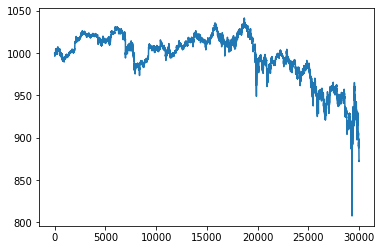

In [72]:
trade(xgbr, 1000, X_test, y_test, CLOSE_test, 30000,0.0032, 0.05)

In [20]:
trade(model_mlp, 1000, X_test, y_test, CLOSE_test, 30000,0.0032, 0.05)

Current price:  36343.0 coins:  0.0078 cash:  571.4618534276946 total:  855.96
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


In [21]:
trade(model_lstm, 1000, X_test_lstm, y_test, CLOSE_test, 30000,0.0032, 0.05)

Current price:  36343.0 coins:  0.0079 cash:  575.4836479990523 total:  861.98
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


In [22]:
trade(c_linreg, 1000, X_test, y_test, CLOSE_test, 30000,0.0032, 0.05)

Current price:  36343.0 coins:  0.008 cash:  584.8639751239964 total:  876.03
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


In [23]:
trade(c_lgb, 1000, X_test, y_test, CLOSE_test, 30000,0.0032, 0.05)

Current price:  36343.0 coins:  0.0078 cash:  568.9033638320576 total:  852.13
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


In [24]:
trade(xgbr, 1000, X_test, y_test, CLOSE_test, 30000,0.0032, 0.04)

Current price:  36343.0 coins:  0.008 cash:  583.8565361498555 total:  874.52
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


In [27]:
trade(rfr, 1000, X_test, y_test, CLOSE_test, 30000,0.0032, 0.04)

Current price:  36343.0 coins:  0.0081 cash:  589.9147597031647 total:  883.6
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


# Silly benchmark

In [ ]:
def benchmark(model, X_test, y_test):
 
  y_pred = model.predict(X_test[1: -1])
  y_silly = y_test[:-2]
  y_test = y_test[1: -1]

  print("Silly metrics:")
  print("MAE: ", mean_absolute_error(y_test, y_silly))
  print("MSE:", mean_squared_error(y_test, y_silly))
  print("MAPE", mean_absolute_percentage_error(y_test, y_silly))

  print("Model metrics: ")
  print("MAE: ", mean_absolute_error(y_test, y_pred))
  print("MSE:", mean_squared_error(y_test, y_pred))
  print("MAPE", mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
benchmark(c_linreg, X_test, y_test)

Silly metrics:
MAE:  73.29164601947092
MSE: 12041.949882008163
MAPE 1022.9435890010759
Model metrics: 
MAE:  7.6697100339002695
MSE: 135.358657096351
MAPE 26.44896199525461


In [53]:
def trade_true(model, money, X_test, y_test, prices, steps=len(X_test), threshold=0.001, stoploss=0.08):
  coins = 0
  cash = money
  fee = 0.01 / 100
  buylast = False
  soldlast = False
  X_test = X_test[-steps:]
  y_test = y_test[-steps:]
  prices = prices[-steps:]
  buyprice = prices[0]
  sellprice = prices[0]
  history = [money]
  for i in range(steps-1):
    current = prices[i]
    if (i == steps-2): 
      print("Current price: ", current, "coins: ", round(coins, 4), "cash: ", cash, "total: ", round(cash + coins * current * (1 - fee), 2))
    
    d = y_test[i+1]
    if (not buylast and not soldlast) and abs(d) > current * threshold:
      if d > 0: 
        # Пойдет вверх => покупаем
        if (cash != 0):
          coins += (0.5*cash * (1 - fee)) / current
          buyprice=current
          buylast = True
          cash = 0.5*cash

      elif d < 0:
        # Пойде вниз => продаем , купим в след шаге(??)
        if (coins != 0):
          cash += (0.5 * coins  * (1 - fee)) * current
          sellprice = current
          soldlast = True
          coins = 0.5 * coins
    elif buylast:
      buylast = False
      cash += (0.5*coins * (1 - fee)) * current
      coins = 0.5 * coins
    elif soldlast:
      soldlast = False
      coins += (0.5*cash * (1 - fee)) / current
      cash = 0.5 * cash

    history.append(cash + coins * current)
  print("Start price: ", prices[0], "Close price: ", prices[-1])
  print("Passive profit: ", prices[-1] / prices[0] * money * (1 - fee))
  plt.plot(range(len(history)), history)
#trade(xgbr, 10000, X_test, y_test, CLOSE_test, 10000, 0.0005)
        







Current price:  36222.56 coins:  0.0322 cash:  2365.021219228658 total:  3532.5
Start price:  53928.95 Close price:  36343.0
Passive profit:  673.8378125292631


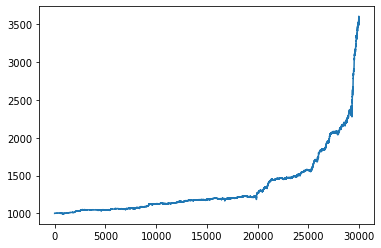

In [54]:
trade_true(c_linreg, 1000, X_test, y_test, CLOSE_test, 30000,0.0032)